# DNN retrieval comparison

---

## Imports

In [1]:
import sys
import os
import glob
import numpy as np
import pandas as pd
import dask.dataframe as dd
import xarray as xr
import seaborn as sns
from dask import delayed, compute
import itertools
from scipy.constants import c
from scipy import stats as ss
from scipy.optimize import minimize
from scipy.optimize import brentq
from scipy.special import gamma
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from dask.distributed import Client, LocalCluster
from sklearn.model_selection import train_test_split

from matplotlib.colors import ListedColormap
from matplotlib import rc
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
from re import split
import matplotlib.dates as mdates
import matplotlib.transforms as mtransforms
from dask_jobqueue import SLURMCluster
from dask.distributed import Client, progress
import matplotlib.pylab as pl
from dask import delayed, compute
from collections import Counter

import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers

warnings.filterwarnings('ignore')


sys.path.insert(1, f"{os.path.abspath(os.path.join(os.path.abspath(''), '../'))}")
from src.utils import get_pars_from_ini, make_dir

location = split(', |_|-|!', os.popen('hostname').read())[0].replace("\n", "")
path_data = get_pars_from_ini(file_name='loc')[location]['path_data']

/data/keeling/a/alfonso8/miniconda3/envs/camp2ex_proj/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
2023-12-08 11:18:26.039231: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def norm_gamma(d, nw, mu, dm):
    f_mu = (6 * (4 + mu) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4) )
    slope = (4 + mu) / dm
    return nw * f_mu * (d / dm) ** mu * np.exp(-slope * d)

def plot_history(history):
    fig, (ax, ax1) = plt.subplots(1, 2, figsize=(12, 5))
    hist['epoch'] = history.epoch


    ax.set_xlabel('$Epoch$')
    ax.set_ylabel('$Loss$')
    ax.set_title('$Mean \ Absolute \  Error$')
    ax.plot(hist['epoch'], hist['mae'], label='$Training$')
    try:
        ax.plot(hist['epoch'], hist['val_mae'], label='$Validation$')
    except KeyError:
        pass
    # plt.ylim([0,5])
    ax.legend()

    ax1.set_xlabel('$Epoch$')
    ax1.set_ylabel("$Loss$")
    ax1.set_title('$Mean \ Square \ Error$')
    ax1.plot(hist['epoch'], hist['mse'],
             label='$Training$')
    try:
        ax1.plot(hist['epoch'], hist['val_mse'],
                  label='$Validation$')
    except KeyError:
        pass
    # plt.ylim([0,3])
    ax1.legend()
    plt.savefig("../results/loss.jpeg",  bbox_inches="tight")
    plt.show()
    

def metrics_pd(x, xpred):
    xpred = xpred.astype(float)
    x = x.astype(float)
    x = x[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    xpred = xpred[(~np.isnan(xpred)) & (~np.isinf(xpred))]
    rmse = np.sqrt(np.sum((xpred - x) ** 2 / len(x)))
    mae = np.sum(np.abs(xpred - x)) / len(x)
    corr = np.corrcoef(x, xpred)**2.
    return rmse, mae, corr[0, 1]

def rain_retrieval(nw, mu, dm, d, d_d, vel_m='lerm'):
    lerm_vel: Callable[[float], float] = lambda diam: 9.25 * (1 - np.exp(-0.068 * diam ** 2 - 0.488 * diam))  # d in mm
    ulbr_vel: Callable[[float], float] = lambda diam: 3.78 * diam ** 0.67  # with d in mm
    if vel_m == 'lemr':
        vel = lerm_vel(d)
    else:
        vel = ulbr_vel(d)
    f_mu = (6 * (mu + 4) ** (mu + 4)) / (4 ** 4 * gamma(mu + 4))
    r = 6 * np.pi * 1e-4 * (nw * f_mu * (d / dm) ** mu * np.exp(-(4 + mu) * (d / dm)) * vel * d ** 3 * d_d)
    return r.sum('diameter')

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)#

In [3]:
cluster = LocalCluster()  
cluster

In [4]:
my_cmap6 = ListedColormap(sns.color_palette('deep', 6))
colors6 = my_cmap6(np.linspace(0,1,6))
sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set(style='white', font_scale=0.9)
sns.set_style("ticks")
# rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})

## Data

In [5]:
store1 = f"{path_data}/cloud_probes/zarr/combined_psd_Lear_600_1000_5_bins.zarr"
ds_lear = xr.open_zarr(store1)
df = pd.read_parquet("/data/keeling/a/alfonso8/gpm/camp2ex/cloud_probes/parquet/df_cluster.parquet")
df['mu_3'] = 3
df.shape

(8710, 49)

## DNN model

In [6]:
model_path = f"{path_data}/cloud_probes/model/nn_zku_Dfr_temp_ka_val_10_16x6.h5"
model =  tf.keras.models.load_model(model_path)

In [7]:
X = df[['dbz_t_ku', 'dfr', 'temp', 'Att_ka', 'log10_nw', 'dm', 'new_mu']]
Y = df[['dm_class',  'r', 'kmeans', 'time', 'r_dm_gm_mu_3', 'r_gpm_operational', 'r_true_nw_mu_dm', 'dm_rt_dfr_nd_mu_3', 'log10nw_dm_gm_mu_3', 'mu_3']]

In [8]:
scaler_x = StandardScaler()
X_scaled = scaler_x.fit_transform(X)
scaler_y = StandardScaler()
Y_scaled = scaler_y.fit_transform(X[['log10_nw', 'dm', 'new_mu']])
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=40, stratify=df.kmeans)
X_train.shape

(6968, 7)

In [9]:
yhat = model.predict(X_test[:, :4])
yhat = scaler_y.inverse_transform(yhat)
y_test_unscaled = scaler_y.inverse_transform(X_test[:, 4:])

55/55 [==============================] - 0s 692us/step


In [10]:
n_c = 6

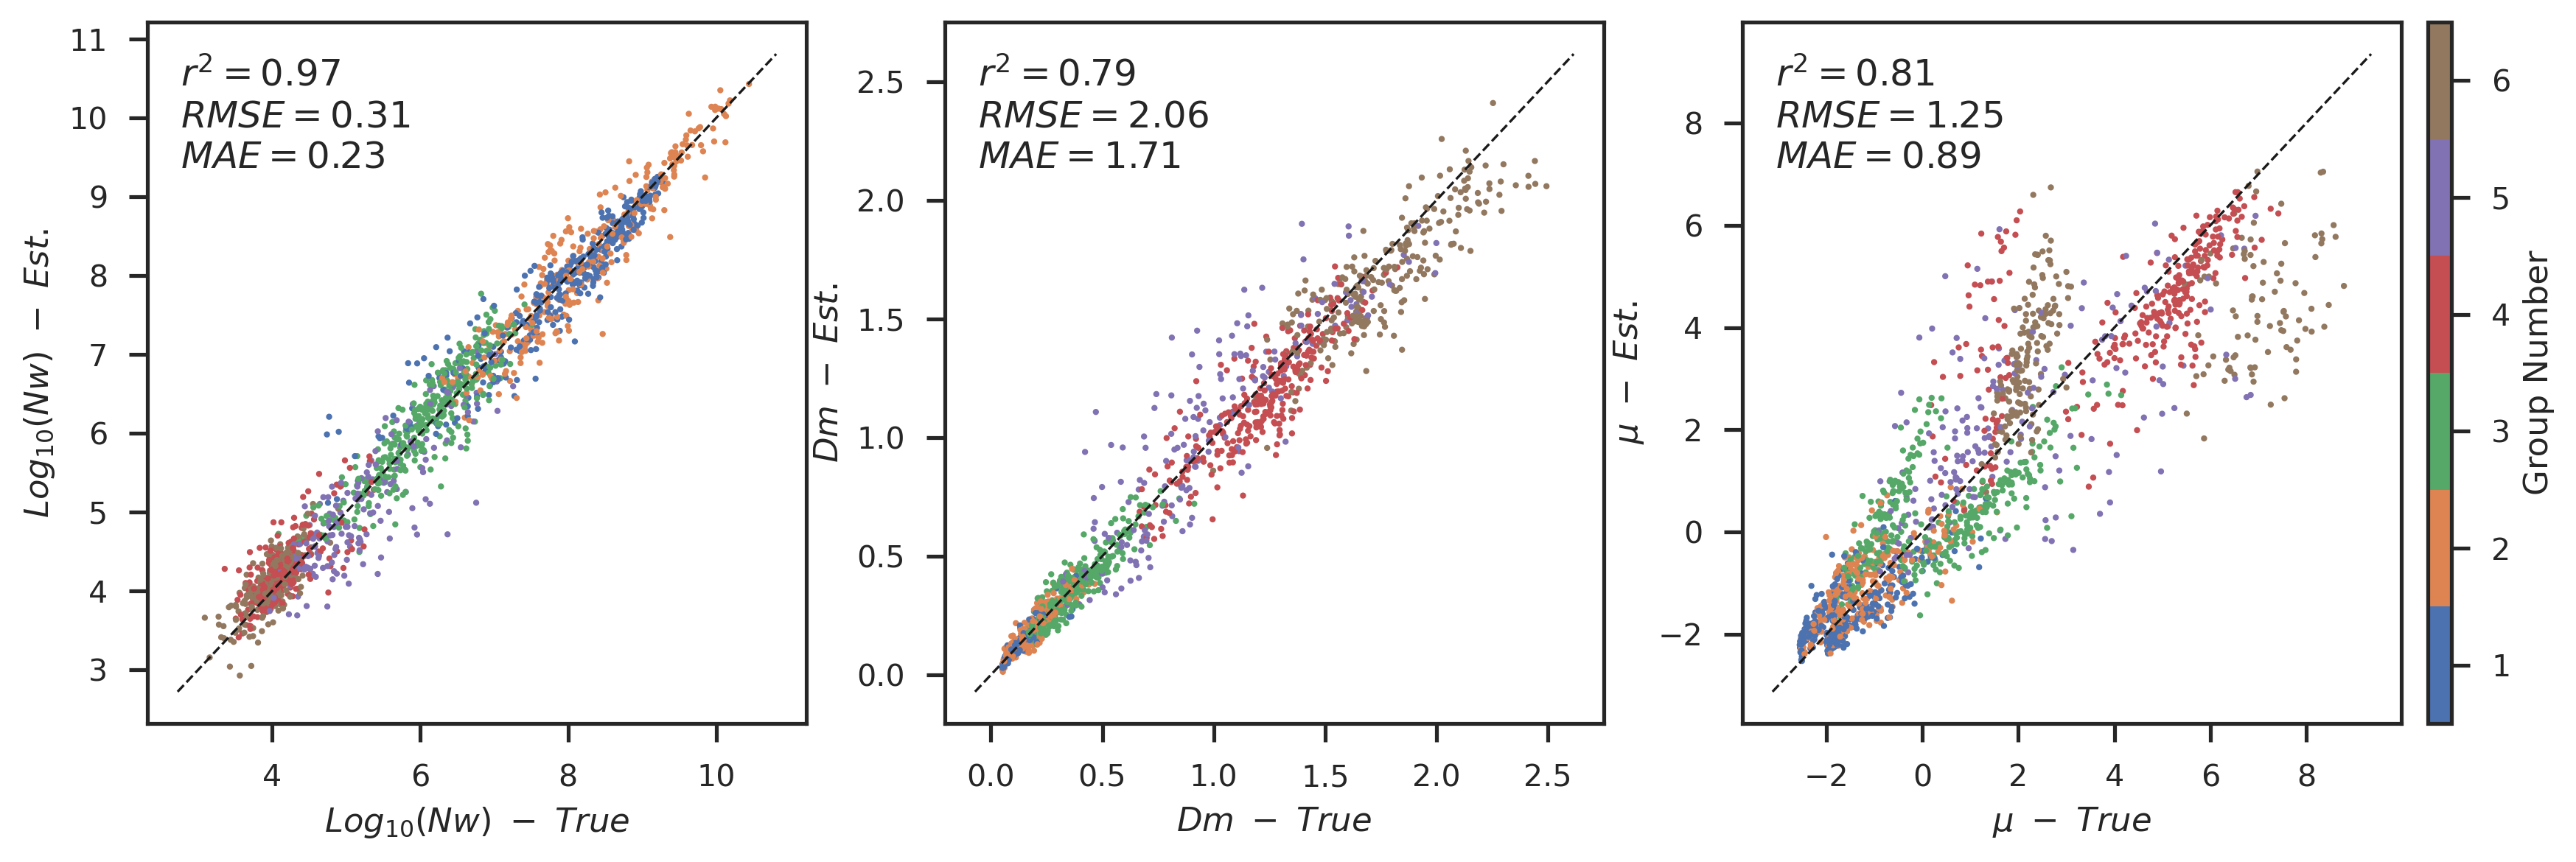

In [11]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4), dpi=300)
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12, verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test.kmeans, cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

## GPM Analythical solution (Liao et al., 2014)

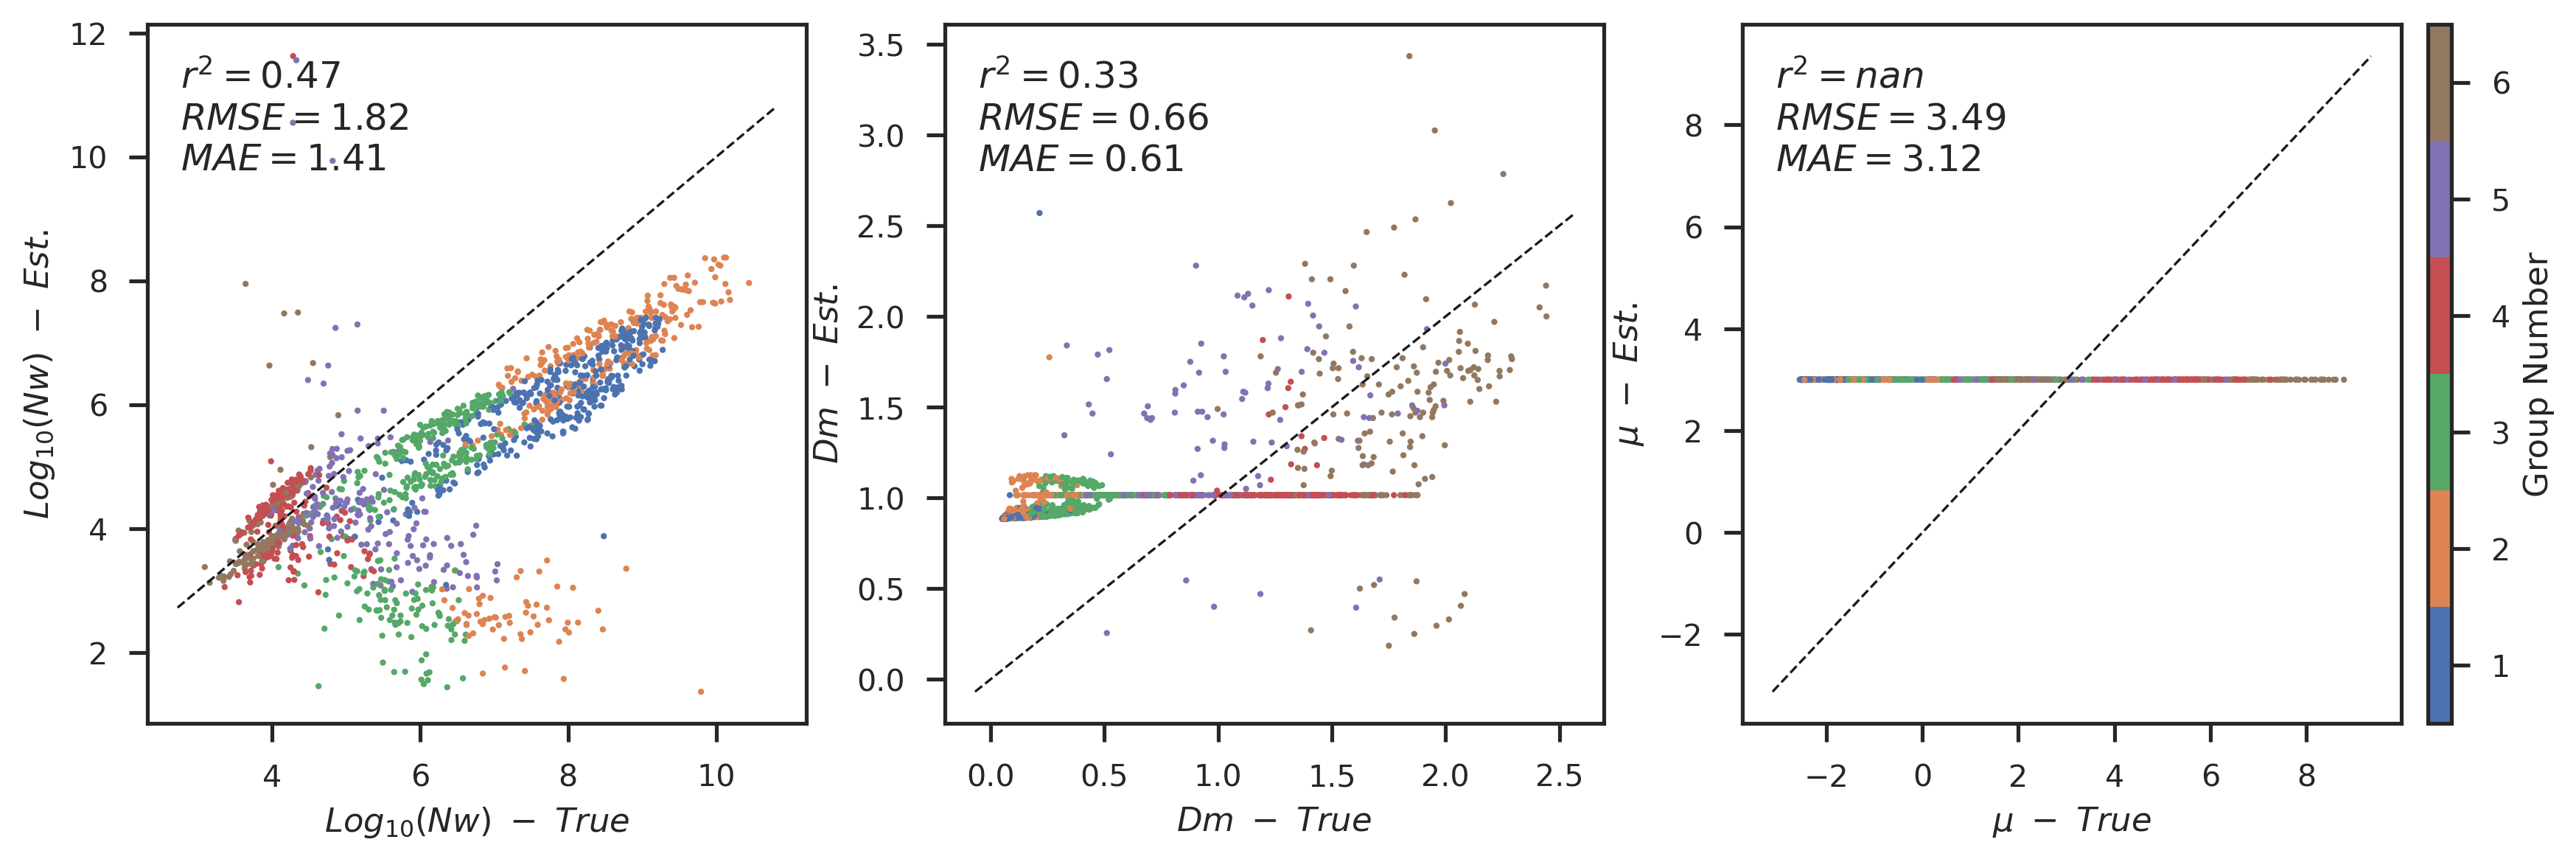

In [12]:
# 'log10_nw', 'dm', 'mu'
fig, (ax, ax1, ax2) = plt.subplots(1, 3, figsize=(13, 4), dpi=300)
ax.scatter(y_test_unscaled[:, 0], y_test.log10nw_dm_gm_mu_3 / 10, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], y_test.log10nw_dm_gm_mu_3 / 10)

textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')

ax1.scatter(y_test_unscaled[:, 1], y_test.dm_rt_dfr_nd_mu_3, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], y_test.dm_rt_dfr_nd_mu_3)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')

sc1 = ax2.scatter(y_test_unscaled[:, 2], y_test.mu_3, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], y_test.mu_3)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
plt.tight_layout()
cbar = fig.colorbar(sc1, ax=[ax, ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

## NGSD parameter retrieval comparison

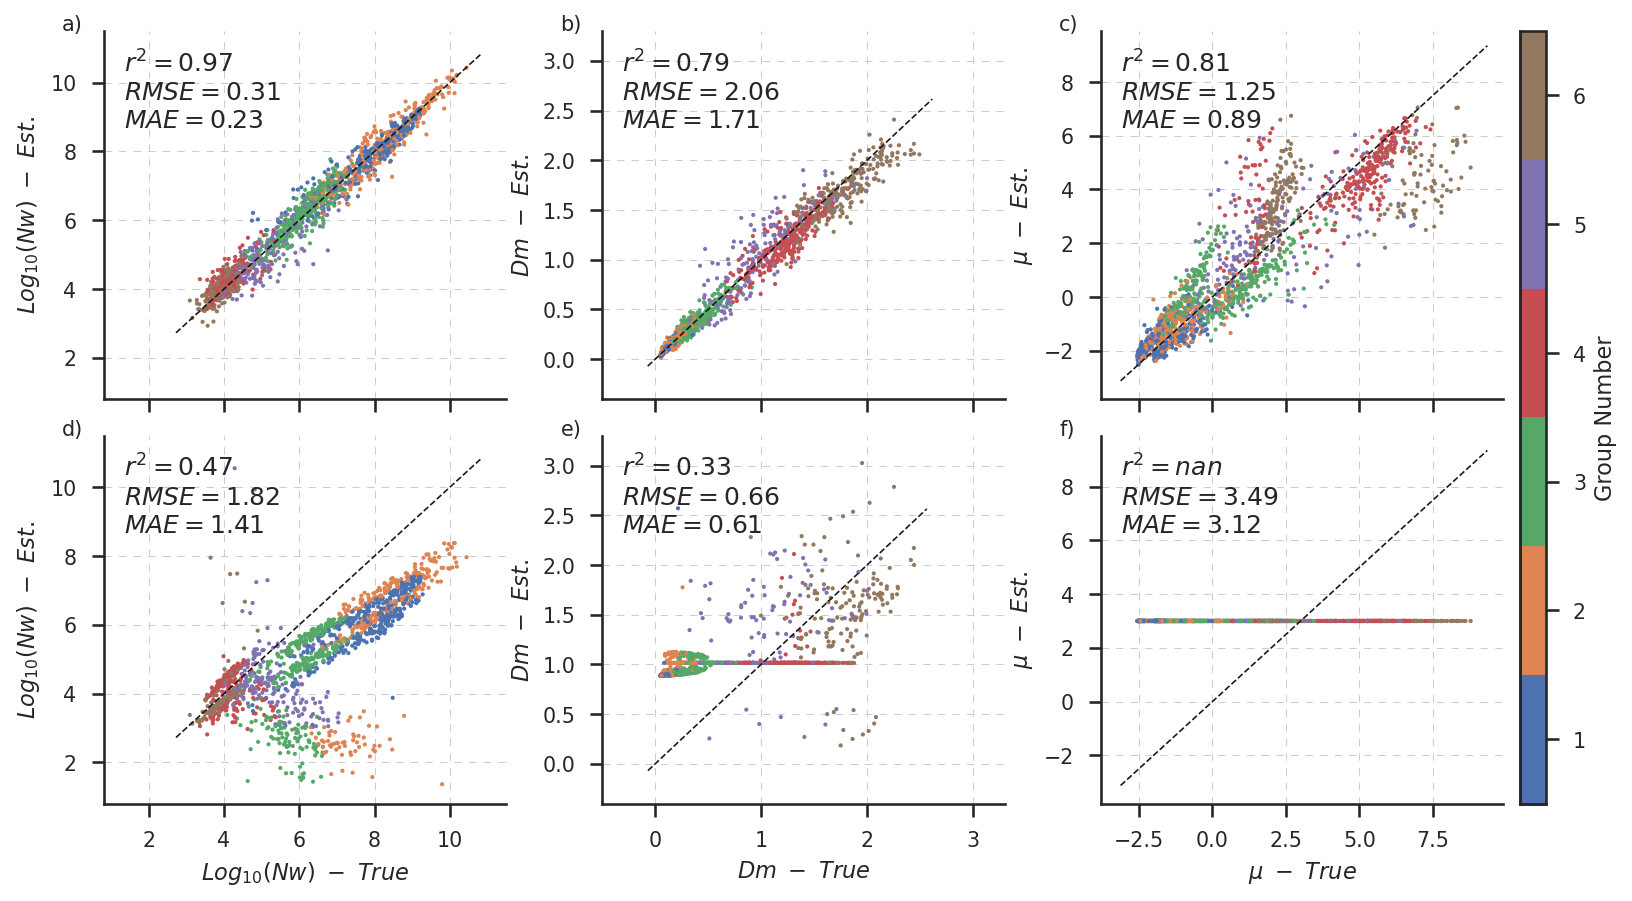

In [13]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)'], ['d)', 'e)', 'f)']], figsize=(12,6), dpi=150)

ax = axs['a)']
ax.scatter(y_test_unscaled[:, 0], yhat[:, 0], s=1, c=y_test.kmeans, cmap=my_cmap6)
# ax.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], yhat[:, 0])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax.set_xlim(0.8, 11.5)
ax.set_ylim(0.8, 11.5)
ax.set_xticklabels("")


ax1 = axs['b)']
ax1.scatter(y_test_unscaled[:, 1], yhat[:, 1], s=1, c=y_test.kmeans, cmap=my_cmap6)
# ax1.set_xlabel(r"$Dm \ - \ True $")
ax1.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax1.get_xlim())
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
# ax1.set_xlim(-0.5, 3)
# ax1.set_ylim(-0.5, 3)
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_xlim(-0.5, 3.3)
ax1.set_ylim(-0.4, 3.3)
ax1.set_xticklabels("")


ax2 = axs['c)']
sc2 = ax2.scatter(y_test_unscaled[:, 2], yhat[:, 2], s=1, c=y_test.kmeans, cmap=my_cmap6)
# ax2.set_xlabel(r"$\mu  \ - \ True $")
ax2.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], yhat[:, 2])
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax2.get_xlim())
ax2.plot(x, x, c='k', ls='--', lw=0.8)
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.set_xlim(-3.8, 9.9)
ax2.set_ylim(-3.8, 9.9)
ax2.set_xticklabels("")

ax3 = axs['d)']
ax3.scatter(y_test_unscaled[:, 0], y_test.log10nw_dm_gm_mu_3 / 10, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax3.set_xlabel(r"$Log_{10}(Nw) \ - \ True $")
ax3.set_ylabel(r"$Log_{10}(Nw) \ - \ Est. $")
x = np.linspace(*ax3.get_xlim())
ax3.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 0], y_test.log10nw_dm_gm_mu_3 / 10)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax3.text(0.05, 0.95, textstr, transform=ax3.transAxes, fontsize=12,
        verticalalignment='top')
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax3.set_xlim(0.8, 11.5)
ax3.set_ylim(0.8, 11.5)

ax4 = axs['e)']
ax4.scatter(y_test_unscaled[:, 1], y_test.dm_rt_dfr_nd_mu_3, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax4.set_xlabel(r"$Dm \ - \ True $")
ax4.set_ylabel(r"$Dm \ - \ Est. $")
x = np.linspace(*ax4.get_xlim())
ax4.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 1], y_test.dm_rt_dfr_nd_mu_3)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax4.text(0.05, 0.95, textstr, transform=ax4.transAxes, fontsize=12,
        verticalalignment='top')
ax4.set_xlim(-0.5, 3.3)
ax4.set_ylim(-0.4, 3.3)
ax4.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

ax5 = axs['f)']
ax5.scatter(y_test_unscaled[:, 2], y_test.mu_3, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax5.set_xlabel(r"$\mu  \ - \ True $")
ax5.set_ylabel(r"$\mu \ - \ Est. $")
rmse, mae, corr1 = metrics_pd(y_test_unscaled[:, 2], y_test.mu_3)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax5.text(0.05, 0.95, textstr, transform=ax5.transAxes, fontsize=12,
        verticalalignment='top')
x = np.linspace(*ax5.get_xlim())
ax5.plot(x, x, c='k', ls='--', lw=0.8)
ax5.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax5.set_xlim(-3.8, 9.9)
ax5.set_ylim(-3.8, 9.9)

plt.tight_layout()
plt.subplots_adjust(wspace=None, hspace=0.1)

cbar = fig.colorbar(sc2, ax=[ax, ax1, ax2, ax3, ax4, ax5], aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
sns.despine()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-20/72, 8/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
    
plt.savefig("../results/DNN_Retrieval_Comp.svg", bbox_inches='tight')

## Rainfall rate assesment

In [14]:
nw = yhat[:, 0]
dm = yhat[:, 1]
mu_unc = yhat[:, 2]

ds_sub = xr.Dataset(
    data_vars=dict(
        nw = (["time"], 10 ** nw),
        dm = (["time"], dm),
        mu_unc = (["time"], mu_unc),
    ), 
    coords=dict(
        time=(["time"], y_test.time.values),
        diameter=(['diameter'], ds_lear.diameter.values)
    ),
)

d_d = ds_lear.d_d.isel(time=0).values
d_d = np.tile(d_d, (ds_sub.nw.shape[0], 1))
d_d = xr.DataArray(data=d_d,
                   dims=['time', "diameter"])
ds_sub['d_d'] = d_d

In [15]:
ds_sub['nn_gamma_pds'] = norm_gamma(ds_lear.diameter/100, nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm)
nn_rain = rain_retrieval(nw=ds_sub.nw, mu=ds_sub.mu_unc, dm=ds_sub.dm, d=ds_sub.diameter/1e3, d_d=ds_sub.d_d/1e3, vel_m='das')

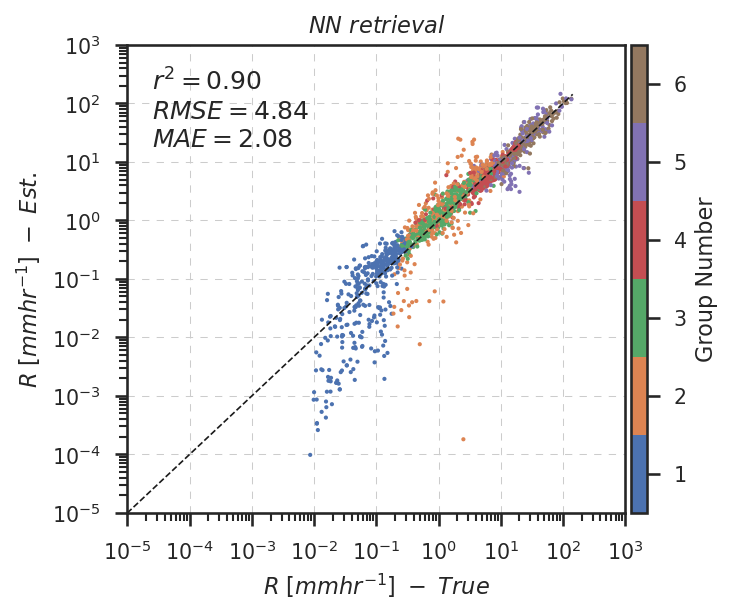

In [16]:
# 'log10_nw', 'dm', 'mu'
fig, ax = plt.subplots(figsize=(5, 4), dpi=150)
sc1 = ax.scatter(y_test.r, nn_rain.values, s=1, c=y_test.kmeans, cmap=my_cmap6)
ax.set_xlabel(r"$R \ [mmhr^{-1}]\ - \ True $")
ax.set_ylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $")
x = np.linspace(*ax.get_xlim())
ax.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test.r, nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
plt.tight_layout()

ax.set_title(r"$NN \ retrieval$")
ax.set_ylim(1e-5, 1e3)
ax.set_xlim(1e-5, 1e3)
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

cbar = fig.colorbar(sc1, ax=ax, aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))

plt.savefig("../results/rr_ka.jpeg",  bbox_inches="tight")

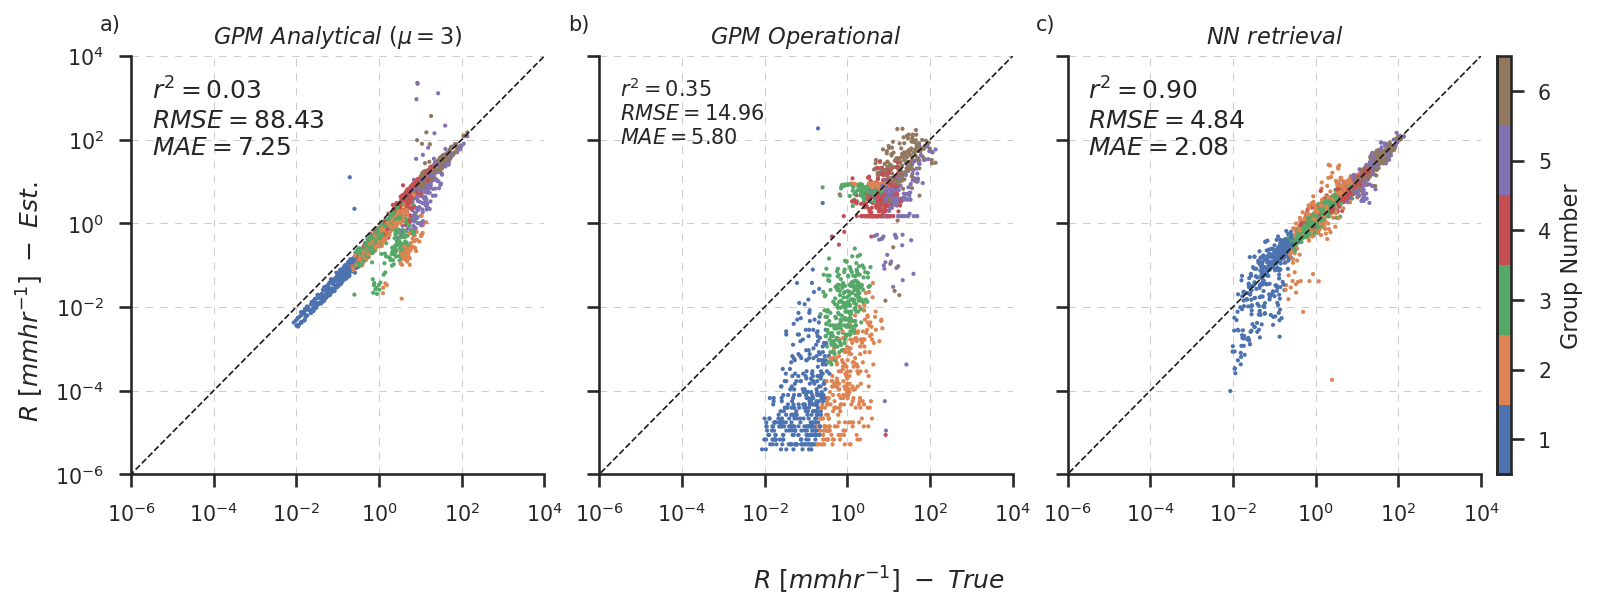

In [17]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)']], figsize=(12,4), dpi=150, sharey=True)

ax = axs['a)']
sc1 = ax.scatter(y_test.r, y_test.r_dm_gm_mu_3, s=1, c=y_test.kmeans, cmap=my_cmap6)
_min, _max = ax.get_xlim()
x = np.linspace(_min, _max + 1e4) 
ax.plot(x, x, c='k', ls='--', lw=0.8)
ax.set_ylim(1e-6, 10000)
rmse, mae, corr1 = metrics_pd(y_test.r, y_test.r_dm_gm_mu_3)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top')
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(-5, 180)
ax.set_title(r"$GPM \ Analytical \ (\mu=3)$")

ax1 = axs['c)']
sc1 = ax1.scatter(y_test.r, nn_rain.values, s=1, c=y_test.kmeans, cmap=my_cmap6)
_min, _max = ax1.get_xlim()
x = np.linspace(_min, _max + 1e4) 
ax1.plot(x, x, c='k', ls='--', lw=0.8)
rmse, mae, corr1 = metrics_pd(y_test.r, nn_rain.values)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax1.text(0.05, 0.95, textstr, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top')
ax1.set_xscale('log')
ax1.set_yscale('log')


ax2 = axs['b)']
sc1 = ax2.scatter(y_test.r, y_test.r_gpm_operational, s=1, c=y_test.kmeans, cmap=my_cmap6)
_min, _max = ax2.get_xlim()
x = np.linspace(_min, _max + 1e4) 
ax2.plot(x, x, c='k', ls='--', lw=0.8)

rmse, mae, corr1 = metrics_pd(y_test.r, y_test.r_gpm_operational)
textstr = '\n'.join((
    r'$r^2=%.2f$' % (corr1, ),
    r'$RMSE=%.2f$' % (rmse, ),
    r'$MAE=%.2f$' % (mae, )))
ax2.text(0.05, 0.95, textstr, transform=ax2.transAxes, 
        verticalalignment='top')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_title(r"$GPM \ Operational$")

fig.supxlabel(r"$R \ [mmhr^{-1}]\ - \ True $", fontsize=12)
fig.supylabel(r"$R \ [mmhr^{-1}] \ - \ Est. $", fontsize=12)

ax.set_ylim(1e-6, 1e4)
ax.set_xlim(1e-6, 1e4)
ax.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

ax1.set_ylim(1e-6, 1e4)
ax1.set_xlim(1e-6, 1e4)
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

ax2.set_ylim(1e-6, 1e4)
ax2.set_xlim(1e-6, 1e4)
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])

plt.tight_layout()

cbar = fig.colorbar(sc1, ax=[ax,ax1, ax2], aspect=30, pad=0.01, label='Group Number')
tick_locs = ((np.arange(n_c) + 0.5) * (n_c - 1) / n_c) +1
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(np.arange(1, n_c+1))
sns.despine()
ax1.set_title(r"$NN \ retrieval$")

for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-15/72, 20/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')

plt.savefig("../results/r_comparison.svg", bbox_inches='tight')

In [18]:
df_test = pd.DataFrame(data=y_test_unscaled, columns=['log10_nw', 'dm', 'mu'])
df_est = pd.DataFrame(data=yhat, columns=['log10_nw_hat', 'dm_hat', 'mu_hat'])

In [19]:
df_dnn = pd.concat([df_test, df_est], axis=1)

In [20]:
df_dnn['dm_error'] = 100 * (df_dnn['dm'] - df_dnn['dm_hat']) /  df_dnn['dm']
df_dnn['log10_nw_error'] = 100 * (df_dnn['log10_nw'] - df_dnn['log10_nw_hat']) /  df_dnn['log10_nw']
df_dnn['mu_error'] = 100 * (df_dnn['mu'] - df_dnn['mu_hat']) /  df_dnn['mu']

In [21]:
df_dnn['dm_error'].quantile([0.25, 0.5, 0.75])

0.25    -5.033977
0.50     4.362783
0.75    13.097171
Name: dm_error, dtype: float64

In [22]:
df_dnn['log10_nw_error'].quantile([0.25, 0.5, 0.75])

0.25   -3.752986
0.50   -0.395713
0.75    2.322665
Name: log10_nw_error, dtype: float64

In [23]:
df_dnn['mu_error'].quantile([0.25, 0.5, 0.75])

0.25   -20.785361
0.50    13.042325
0.75    43.329337
Name: mu_error, dtype: float64

In [24]:
# df['dm_q'] = pd.cut(df['dm'], 10, labels)
df_dnn['dm_q'], bins = pd.cut(df_dnn['dm'], 20, retbins=True)
df_dnn['dm_q'] = df_dnn['dm_q'].apply(lambda x: x.values.mid.values)
df_dnn['nw_q'], bins = pd.cut(df_dnn['log10_nw'], 20, retbins=True)
df_dnn['nw_q'] = df_dnn['nw_q'].apply(lambda x: x.values.mid.values)
df_dnn['mu_q'], bins = pd.cut(df_dnn['mu'], 20, retbins=True)
df_dnn['mu_q'] = df_dnn['mu_q'].apply(lambda x: x.values.mid.values)

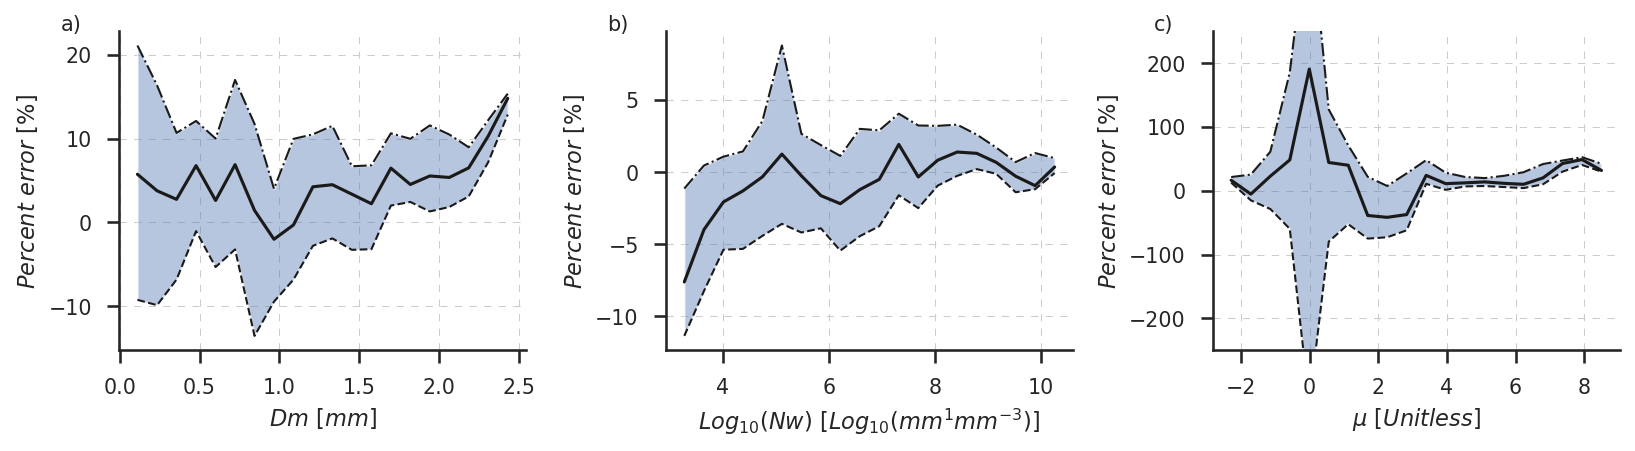

In [25]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)']], figsize=(11,3), dpi=150)
df_dm = df_dnn.groupby('dm_q').quantile([0.25, .5, 0.75])
data = df_dm['dm_error'].unstack().reset_index()
ax1 = axs['a)']
ax1.plot(data.dm_q, data[data.columns[1]], ls='--', c='k', lw=1)
ax1.plot(data.dm_q, data[data.columns[2]], ls='-', c='k')
ax1.plot(data.dm_q, data[data.columns[3]], ls='dashdot', c='k', lw=1)
ax1.fill_between(data.dm_q, data[data.columns[3]], data[data.columns[1]], alpha=0.4)
ax1.set_ylabel(r"$Percent \ error \ [\%]$")
ax1.set_xlabel(r"$Dm \ [mm]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])


df_dm = df_dnn.groupby('nw_q').quantile([0.25, .5, 0.75])
data1 = df_dm['log10_nw_error'].unstack().reset_index()
ax2 = axs['b)']
ax2.plot(data1.nw_q, data1[data1.columns[1]], label=0.25, ls='--', c='k', lw=1)
ax2.plot(data1.nw_q, data1[data1.columns[2]], label=0.5, ls='-', c='k')
ax2.plot(data1.nw_q, data1[data1.columns[3]],label=0.75, ls='dashdot', c='k', lw=1)
ax2.fill_between(data1.nw_q, data1[data1.columns[3]], data1[data1.columns[1]], alpha=0.4)
ax2.set_ylabel(r"$Percent \ error \ [\%]$")
ax2.set_xlabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax2.legend()|

df_dm = df_dnn.groupby('mu_q').quantile([0.25, .5, 0.75])
data2 = df_dm['mu_error'].unstack().reset_index()
ax3 = axs['c)']
ax3.plot(data2.mu_q, data2[data2.columns[1]], ls='--', c='k', lw=1)
ax3.plot(data2.mu_q, data2[data2.columns[2]], ls='-', c='k')
ax3.plot(data2.mu_q, data2[data2.columns[3]], ls='dashdot', c='k', lw=1)
ax3.fill_between(data2.mu_q, data2[data2.columns[3]], data2[data2.columns[1]], alpha=0.4)
ax3.set_ylabel(r"$Percent \ error \ [\%]$")
ax3.set_xlabel("$\mu \ [Unitless]$")
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax3.set_ylim(-250, 250)
sns.despine()
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(-28/72, 8/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
plt.savefig("../results/parameter_error.svg", bbox_inches='tight')

In [26]:
df_gpm = pd.concat([df_test, y_test.reset_index()], axis=1)

df_gpm['dm_error'] = 100 * (df_gpm['dm'] - df_gpm['dm_rt_dfr_nd_mu_3']) /  df_gpm['dm']
df_gpm['log10_nw_error'] = 100 * (df_gpm['log10_nw'] - df_gpm['log10nw_dm_gm_mu_3']) /  df_gpm['log10_nw']
df_gpm['mu_error'] = 100 * (df_gpm['mu'] - df_gpm['mu_3']) /  df_gpm['mu']

In [27]:
df_gpm['dm_error'].quantile([0.25, 0.5, 0.75])

0.25   -672.968003
0.50   -199.119668
0.75    -11.831504
Name: dm_error, dtype: float64

In [28]:
df_gpm['log10_nw_error'].quantile([0.25, 0.5, 0.75])

0.25   -826.424808
0.50   -723.645924
0.75   -654.714027
Name: log10_nw_error, dtype: float64

In [29]:
df_gpm['mu_error'].quantile([0.25, 0.5, 0.75])

0.25    -37.775284
0.50     56.371842
0.75    285.690365
Name: mu_error, dtype: float64

In [30]:
df_gpm['dm_q'], bins = pd.cut(df_gpm['dm'], 20, retbins=True)
df_gpm['dm_q'] = df_gpm['dm_q'].apply(lambda x: x.values.mid.values)
df_gpm['nw_q'], bins = pd.cut(df_gpm['log10_nw'], 20, retbins=True)
df_gpm['nw_q'] = df_gpm['nw_q'].apply(lambda x: x.values.mid.values)
df_gpm['mu_q'], bins = pd.cut(df_gpm['mu'], 20, retbins=True)
df_gpm['mu_q'] = df_gpm['mu_q'].apply(lambda x: x.values.mid.values)

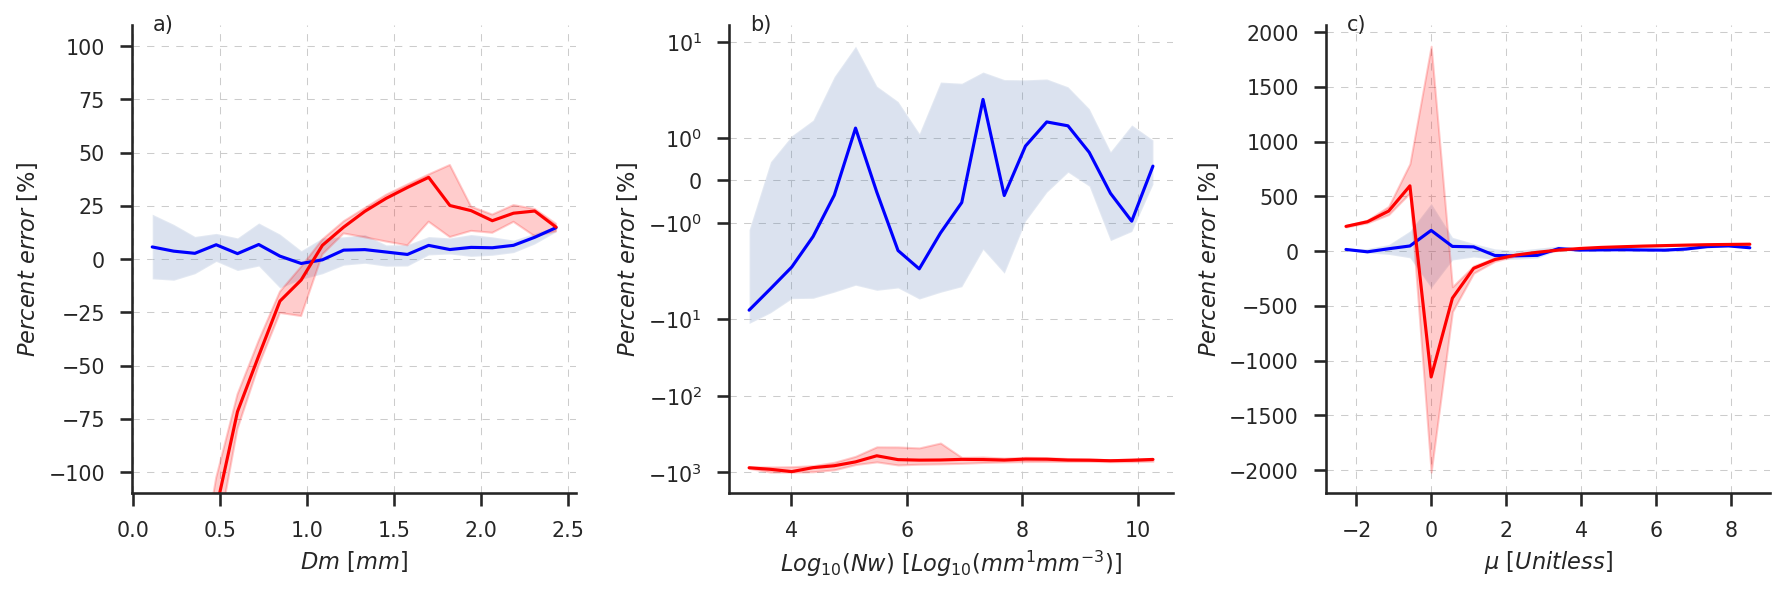

In [31]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)']], figsize=(12,4), dpi=150)

df_dm = df_dnn.groupby('dm_q').quantile([0.25, .5, 0.75])
data = df_dm['dm_error'].unstack().reset_index()
ax1 = axs['a)']
# ax1.plot(data.dm_q, data[data.columns[1]], ls='--', c='k', lw=1)
ax1.plot(data.dm_q, data[data.columns[2]], ls='-', c='blue')
# ax1.plot(data.dm_q, data[data.columns[3]], ls='dashdot', c='k', lw=1)
ax1.fill_between(data.dm_q, data[data.columns[3]], data[data.columns[1]], alpha=0.2)
ax1.set_ylabel(r"$Percent \ error \ [\%]$")
ax1.set_xlabel(r"$Dm \ [mm]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax1.set_yscale('symlog')

df_dm = df_dnn.groupby('nw_q').quantile([0.25, .5, 0.75])
data1 = df_dm['log10_nw_error'].unstack().reset_index()
ax2 = axs['b)']
# ax2.plot(data1.nw_q, data1[data1.columns[1]], label=0.25, ls='--', c='k', lw=1)
ax2.plot(data1.nw_q, data1[data1.columns[2]], label=0.5, ls='-', c='blue')
# ax2.plot(data1.nw_q, data1[data1.columns[3]],label=0.75, ls='dashdot', c='k', lw=1)
ax2.fill_between(data1.nw_q, data1[data1.columns[3]], data1[data1.columns[1]], alpha=0.2)
ax2.set_ylabel(r"$Percent \ error \ [\%]$")
ax2.set_xlabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax2.legend()

df_dm = df_dnn.groupby('mu_q').quantile([0.25, .5, 0.75])
data2 = df_dm['mu_error'].unstack().reset_index()
ax3 = axs['c)']
# ax3.plot(data2.mu_q, data2[data2.columns[1]], ls='--', c='k', lw=1)
ax3.plot(data2.mu_q, data2[data2.columns[2]], ls='-', c='blue')
# ax3.plot(data2.mu_q, data2[data2.columns[3]], ls='dashdot', c='k', lw=1)
ax3.fill_between(data2.mu_q, data2[data2.columns[3]], data2[data2.columns[1]], alpha=0.2)
# ax3.set_ylabel(r"$MPA \ [\%]$")
ax3.set_xlabel("$\mu \ [Unitless]$")
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax3.set_ylim(-250, 250)



df_dm = df_gpm.groupby('dm_q').quantile([0.25, .5, 0.75])
data = df_dm['dm_error'].unstack().reset_index()
ax1 = axs['a)']
# ax1.plot(data.dm_q, data[data.columns[1]], ls='--', c='k', lw=1)
ax1.plot(data.dm_q, data[data.columns[2]], ls='-', c='red')
# ax1.plot(data.dm_q, data[data.columns[3]], ls='dashdot', c='k', lw=1)
ax1.fill_between(data.dm_q, data[data.columns[3]], data[data.columns[1]], alpha=0.2, color='red')
ax1.set_xlabel(r"$Dm \ [mm]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.set_ylim(-110, 110)


df_dm = df_gpm.groupby('nw_q').quantile([0.25, .5, 0.75])
data1 = df_dm['log10_nw_error'].unstack().reset_index()
ax2 = axs['b)']
# ax2.plot(data1.nw_q, data1[data1.columns[1]], label=0.25, ls='--', c='k', lw=1)
ax2.plot(data1.nw_q, data1[data1.columns[2]], label=0.5, ls='-', c='red')
# ax2.plot(data1.nw_q, data1[data1.columns[3]],label=0.75, ls='dashdot', c='k', lw=1)
ax2.fill_between(data1.nw_q, data1[data1.columns[3]], data1[data1.columns[1]], alpha=0.2, color='red')
# ax2.set_ylabel(r"$MPA \ [\%]$")
ax2.set_xlabel("$Log_{10}(Nw) \ [Log_{10}(mm^{1}mm^{-3})]$")
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax2.set_yscale('symlog')

df_dm = df_gpm.groupby('mu_q').quantile([0.25, .5, 0.75])
data2 = df_dm['mu_error'].unstack().reset_index()
ax3 = axs['c)']
# ax3.plot(data2.mu_q, data2[data2.columns[1]], ls='--', c='k', lw=1)
ax3.plot(data2.mu_q, data2[data2.columns[2]], ls='-', c='red')
# ax3.plot(data2.mu_q, data2[data2.columns[3]], ls='dashdot', c='k', lw=1)
ax3.fill_between(data2.mu_q, data2[data2.columns[3]], data2[data2.columns[1]], alpha=0.2, color='red')
ax3.set_ylabel(r"$Percent \ error \ [\%]$")
ax3.set_xlabel("$\mu \ [Unitless]$")
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax3.set_yscale('symlog')
sns.despine()
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, 5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
plt.savefig("../results/parameter_error_dnn_liao.svg", bbox_inches='tight')

In [32]:
df_rain = y_test.reset_index(drop=True)

In [33]:
df_rain['rain_dnn'] = nn_rain.values

In [34]:
df_rain['rain_dnn_error'] =  100 * (df_rain['r'] - df_rain['rain_dnn']) /  df_rain['r']
df_rain['rain_gpm_ana_error'] =  100 * (df_rain['r'] - df_rain['r_dm_gm_mu_3']) /  df_rain['r']
df_rain['rain_gpm__ope_error'] =  100 * (df_rain['r'] - df_rain['r_gpm_operational']) /  df_rain['r']

In [35]:
df_rain['r_q'], bins = pd.cut(df_rain['r'], 20, retbins=True)
df_rain['r_q'] = df_rain['r_q'].apply(lambda x: x.values.mid.values)

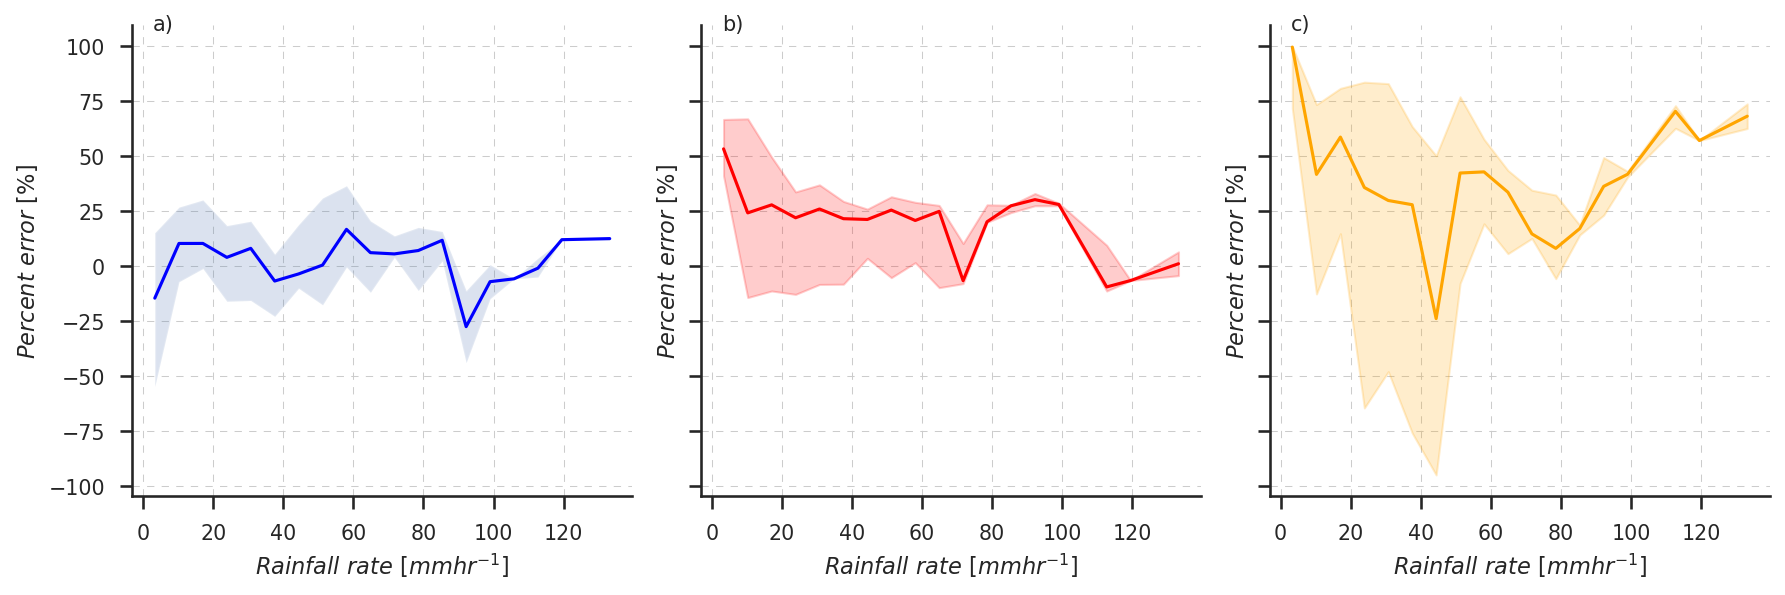

In [36]:
fig, axs = plt.subplot_mosaic([['a)', 'b)', 'c)']], figsize=(12,4), dpi=150, sharey=True)

df_r = df_rain.groupby('r_q').quantile([0.25, .5, 0.75])
data = df_r['rain_dnn_error'].unstack().reset_index()
data = data.dropna()
ax1 = axs['a)']
# ax1.plot(data.r_q, data[data.columns[1]], ls='--', c='k', lw=1)
ax1.plot(data.r_q, data[data.columns[2]], ls='-', c='blue')
# ax1.plot(data.r_q, data[data.columns[3]], ls='dashdot', c='k', lw=1)
ax1.fill_between(data.r_q, data[data.columns[3]], data[data.columns[1]], alpha=0.2)
ax1.set_ylabel(r"$Percent \ error \ [\%]$")
ax1.set_xlabel(r"$Rainfall \ rate \ [mm hr^{-1}]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])


ax2 = axs['b)']
df_r = df_rain.groupby('r_q').quantile([0.25, .5, 0.75])
data = df_r['rain_gpm_ana_error'].unstack().reset_index()
data = data.dropna()
# ax2.plot(data.r_q, data[data.columns[1]], ls='--', c='k', lw=1)
ax2.plot(data.r_q, data[data.columns[2]], ls='-', c='red')
# ax2.plot(data.r_q, data[data.columns[3]], ls='dashdot', c='k', lw=1)
ax2.fill_between(data.r_q, data[data.columns[3]], data[data.columns[1]], alpha=0.2, color='red')
ax2.set_ylabel(r"$Percent \ error \ [\%]$")
ax2.set_xlabel(r"$Rainfall \ rate \ [mm hr^{-1}]$")
ax2.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax1.set_yscale('symlog')

df_r = df_rain.groupby('r_q').quantile([0.25, .5, 0.75])
data = df_r['rain_gpm__ope_error'].unstack().reset_index()
data = data.dropna()
ax3 = axs['c)']
# ax3.plot(data.r_q, data[data.columns[1]], ls='--', c='k', lw=1)
ax3.plot(data.r_q, data[data.columns[2]], ls='-', c='orange')
# ax3.plot(data.r_q, data[data.columns[3]], ls='dashdot', c='k', lw=1)
ax3.fill_between(data.r_q, data[data.columns[3]], data[data.columns[1]], alpha=0.2, color='orange')
ax3.set_ylabel(r"$Percent \ error \ [\%]$")
ax3.set_xlabel(r"$Rainfall \ rate \ [mm hr^{-1}]$")
ax3.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax1.set_yscale('symlog')

sns.despine()
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, 5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
plt.savefig("../results/rr_retrieval_comp.svg", bbox_inches='tight')

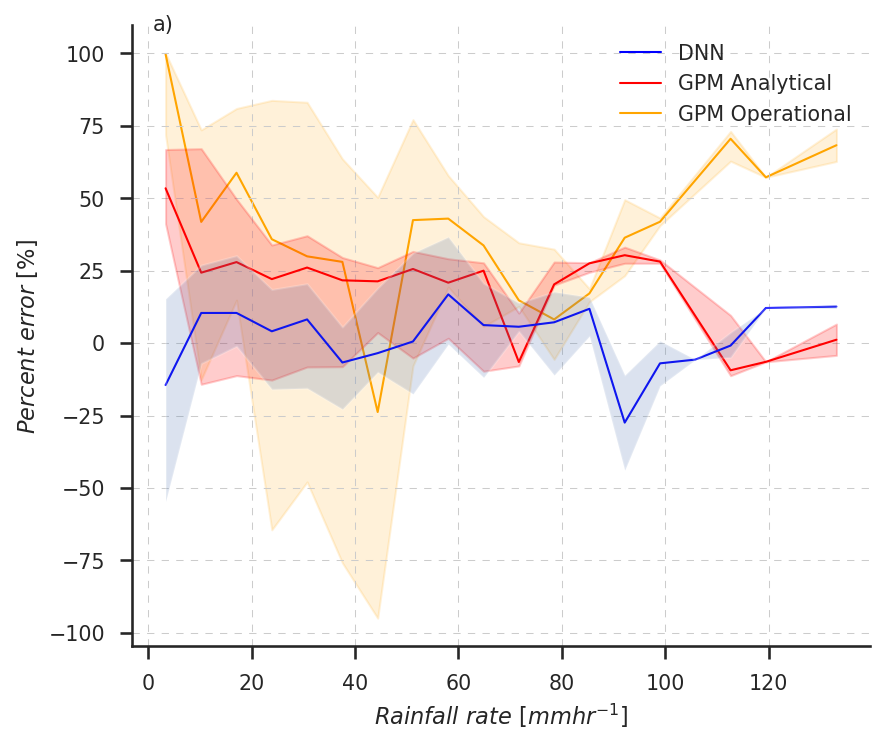

In [37]:
fig, axs = plt.subplot_mosaic([['a)']], figsize=(6, 5), dpi=150)

df_r = df_rain.groupby('r_q').quantile([0.25, .5, 0.75])
data = df_r['rain_dnn_error'].unstack().reset_index()
data = data.dropna()
ax1 = axs['a)']
# ax1.plot(data.r_q, data[data.columns[1]], ls='--', c='k', lw=1)
ax1.plot(data.r_q, data[data.columns[2]], ls='-',c='blue', lw=1, label="DNN",  zorder=10)
# ax1.plot(data.r_q, data[data.columns[3]], ls='dashdot', c='k', lw=1)
ax1.fill_between(data.r_q, data[data.columns[3]], data[data.columns[1]], alpha=0.2,  zorder=10)
ax1.set_ylabel(r"$Percent \ error \ [\%]$")
ax1.set_xlabel(r"$Rainfall \ rate \ [mm hr^{-1}]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])


df_r = df_rain.groupby('r_q').quantile([0.25, .5, 0.75])
data = df_r['rain_gpm_ana_error'].unstack().reset_index()
data = data.dropna()
# ax1.plot(data.r_q, data[data.columns[1]], ls='--', c='k', lw=1)
ax1.plot(data.r_q, data[data.columns[2]], ls='-', c='red', lw=1, label="GPM Analytical", zorder=1)
# ax1.plot(data.r_q, data[data.columns[3]], ls='dashdot', c='k', lw=1)
ax1.fill_between(data.r_q, data[data.columns[3]], data[data.columns[1]], alpha=0.2, color='red', zorder=1)
ax1.set_ylabel(r"$Percent \ error \ [\%]$")
ax1.set_xlabel(r"$Rainfall \ rate \ [mm hr^{-1}]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
# ax1.set_yscale('symlog')

df_r = df_rain.groupby('r_q').quantile([0.25, .5, 0.75])
data = df_r['rain_gpm__ope_error'].unstack().reset_index()
data = data.dropna()
# ax1.plot(data.r_q, data[data.columns[1]], ls='--', c='k', lw=1)
ax1.plot(data.r_q, data[data.columns[2]],  c='orange', lw=1, label="GPM Operational", ls='-', zorder=0)
# ax1.plot(data.r_q, data[data.columns[3]], ls='dashdot', c='k', lw=1)
ax1.fill_between(data.r_q, data[data.columns[3]], data[data.columns[1]], alpha=0.15, color='orange', zorder=0)
ax1.set_ylabel(r"$Percent \ error \ [\%]$")
ax1.set_xlabel(r"$Rainfall \ rate \ [mm hr^{-1}]$")
ax1.grid('both', linestyle='--', lw=0.5, dashes=[7,7])
ax1.legend()

sns.despine()
fig.tight_layout()
for label, ax in axs.items():
    # label physical distance in and down:
    trans = mtransforms.ScaledTranslation(10/72, 5/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', verticalalignment='top')
plt.savefig("../results/rr_retrieval_comp.svg", bbox_inches='tight')

In [38]:
df_r['rain_dnn_error'].quantile([0.25, .5, 0.75])

0.25    -6.998168
0.50     4.055233
0.75    12.581042
Name: rain_dnn_error, dtype: float64

In [39]:
df_r['rain_gpm_ana_error'].quantile([0.25, .5, 0.75])

0.25    -4.941726
0.50    23.166856
0.75    28.061507
Name: rain_gpm_ana_error, dtype: float64

In [40]:
df_r['rain_gpm__ope_error'].quantile([0.25, .5, 0.75])

0.25    15.401531
0.50    41.818874
0.75    62.719714
Name: rain_gpm__ope_error, dtype: float64